# Task 2 - Landsat 8 false color image

## General instructions

First, update the following cell to have a link to your Homework 4 GitHub repository

**UPDATE THIS LINK** https://github.com/lunacatalan/eds220-hwk-4

Add comments for all your code and commit as needed. Err on the side of commenting and commiting too much for now.

## Overview
The goal of this task is to create a false color image showing the fire scar of the Thomas fire in 2017. 
Read more about false color images here:
[NASA Earth Observatory - Why is that Forest Red and that Cloud Blue?
How to Interpret a False-Color Satellite Image](https://earthobservatory.nasa.gov/features/FalseColor)

## About the data

In this task you will use two datsets:

**First dataset**

A simplified collection of bands (red, green, blue, near-infrared and shortwave infrared) from the Landsat Collection 2 Level-2 atmosperically corrected surface reflectance data, collected by the Landsat 8 satellite. 

Information about Landsat bands from USGS:

- [What are the band designations for the Landsat satellites?](https://www.usgs.gov/faqs/what-are-band-designations-landsat-satellites)

- [Common Landsat Band Combinations](https://www.usgs.gov/media/images/common-landsat-band-combinations)

- [How do I use a scale factor with Landsat Level-2 science products?](https://www.usgs.gov/faqs/how-do-i-use-a-scale-factor-landsat-level-2-science-products)


The data was accessed and pre-processed in the Microsoft Planetary Computer to remove data outside land and coarsen the spatial resolution ([Landsat Collection in MPC](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2)). Data should be used for visualization purposes only. 


**Second dataset**

A shapefile of fire perimeters in California during 2017. 
The [complete file can be accessed in the CA state geoportal](https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all-1/about).

## File management
All your data files must be  inside a directory named 'data' **in your gitignore**. 

## Data access
All data is in the Canvas-week7-homework zip file.

## FINAL CODE

You will use the next cell at the end of the task. Leave it blank for now.

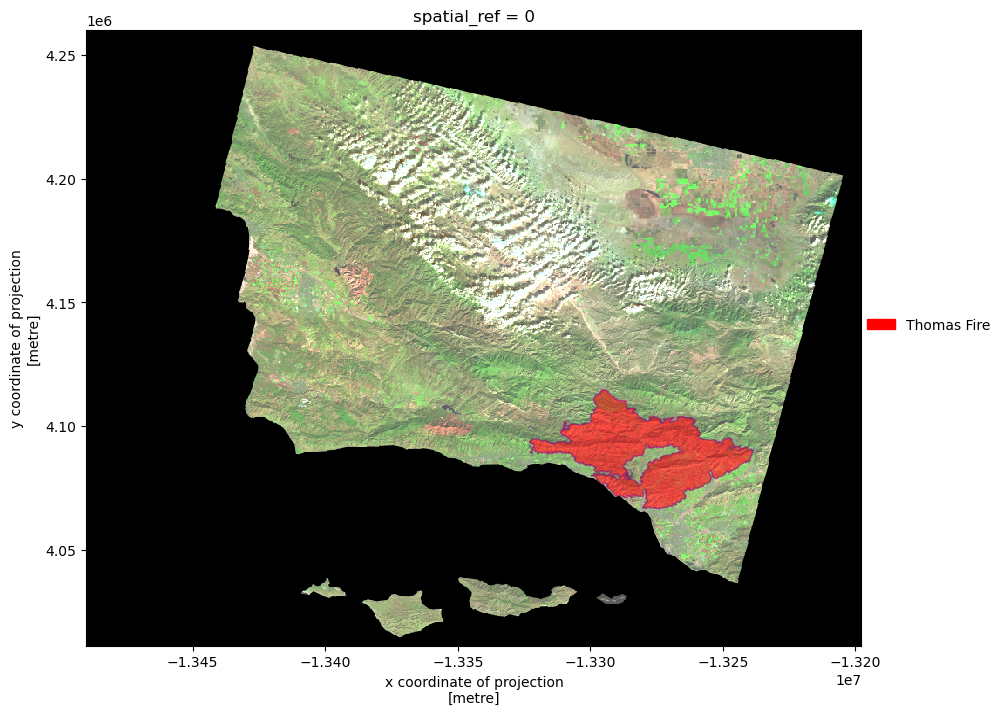

In [1]:
# import libraries
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xarray as xr
import rioxarray as rioxr
import geopandas as gpd

from shapely.geometry import box
import matplotlib.patches as mpatches # to create legends

## ===== Import Data =====

# make filepath for landsat data
landsat_fp = os.path.join(os.getcwd(),
                          'data', 
                          "landsat8-2018-01-26-sb-simplified.nc")

# open raster
landsat = rioxr.open_rasterio(landsat_fp)

# read in california fire shapefile
ca_fire = gpd.read_file(os.path.join(os.getcwd(),
                                    'data',
                                    'California_Fire_Perimeters_2017',
                                    'California_Fire_Perimeters_2017.shp'))

## ===== Updates To Plot Easily =====

# remove band dimension from lulc to be able to plot
landsat = landsat.squeeze().drop('band')

# set all column names to lower case for easier wrangling 
ca_fire.columns = ca_fire.columns.str.lower()

## ===== Updates to plot together =====

# update landsat crs to ca_fire crs 
landsat = landsat.rio.reproject(ca_fire.crs)

# save false color image as an array
landsat_false = landsat[["swir22",
                         "nir08", # plot nir layer
                         "red"]].to_array()

# make landsat bounds into bbox
bbox = gpd.GeoDataFrame({"id":1,
                         "geometry":[box(*landsat.rio.bounds())]}, # landsat bounds
                        crs = ca_fire.crs) # set crs to ca_fire

# select only the Thomas Fires
thomas_fire = ca_fire[ca_fire.fire_name == 'THOMAS']

## ===== Map =====

# set up figure 
fig, ax = plt.subplots(figsize=(10,8))

# plot the fires
thomas_fire.plot(ax = ax,
                 color = "red",
                edgecolor = "purple", # make border around shapefile
                alpha = 0.5) # make transparent
fire_patch = mpatches.Patch(color = "red",
                          label = "Thomas Fire")

# plot the false landsat
landsat_false.plot.imshow(ax = ax,
                          robust = True) 

ax.legend(handles = [fire_patch], # which labels to show 
          frameon = False, # no border around legend
          loc=(1, 0.5)) # where legend is located
 

plt.show()

## Import libraries and functions

In [3]:
# import libraries
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xarray as xr
import rioxarray as rioxr
import geopandas as gpd

from shapely.geometry import box
from shapely.geometry import Polygon
import matplotlib.patches as mpatches # to create legends

## Import data

In [4]:
# make filepath for landsat data
landsat_fp = os.path.join(os.getcwd(),
                          'data', 
                          "landsat8-2018-01-26-sb-simplified.nc")

# open raster
landsat = rioxr.open_rasterio(landsat_fp)

# read in california fire shapefile
ca_fire = gpd.read_file(os.path.join(os.getcwd(),
                                    'data',
                                    'California_Fire_Perimeters_2017',
                                    'California_Fire_Perimeters_2017.shp'))

## Exploration 

Use the next cell(s) to perform relevant explorations of these datasets.

In [5]:
# look at landsat data
print("height:", landsat.rio.height)
print("width:", landsat.rio.width)
print("resolution:", landsat.rio.resolution())
print("bands:", landsat.band)

print('spatial bounding box:')
print(landsat.rio.bounds(), '\n')

height: 731
width: 870
resolution: (270.0, -270.0)
bands: <xarray.DataArray 'band' (band: 1)>
array([1])
Coordinates:
  * band         (band) int64 1
    spatial_ref  int64 0
spatial bounding box:
(121170.0, 3755160.0, 356070.0, 3952530.0) 



I should probably remove the `band` since it only has one dimension. The landsat dataset also has a bunch of color variables.

In [6]:
# check crs
print(f"ca_fire: {ca_fire.crs}\nlandsat: {landsat.rio.crs}")

ca_fire: epsg:3857
landsat: EPSG:32611


In [6]:
# check the columns and the number of values in the ca fire data frame
print("the column names are: ", ca_fire.columns)
ca_fire.info()

the column names are:  Index(['index', 'objectid', 'year_', 'state', 'agency', 'unit_id', 'fire_name',
       'inc_num', 'alarm_date', 'cont_date', 'cause', 'c_method', 'objective',
       'gis_acres', 'comments', 'complex_na', 'complex_in', 'irwinid',
       'fire_num', 'decades', 'shape_leng', 'shape_area', 'geometry'],
      dtype='object')
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 608 entries, 0 to 607
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   index       608 non-null    int64   
 1   objectid    608 non-null    int64   
 2   year_       608 non-null    object  
 3   state       608 non-null    object  
 4   agency      608 non-null    object  
 5   unit_id     608 non-null    object  
 6   fire_name   597 non-null    object  
 7   inc_num     608 non-null    object  
 8   alarm_date  608 non-null    object  
 9   cont_date   606 non-null    object  
 10  cause       608 non-null    floa

## Updates

If there are any updates needed to the data to plot the true and false color images, perform them in the next cells (you may add as many as you need). 
Comment appropriately.

In [21]:
# remove band dimension from lulc
landsat = landsat.squeeze().drop('band')

# set all column names to lower case
ca_fire.columns = ca_fire.columns.str.lower()

## True color image

Without creating any new variables:

Select the red, green and blue variables (in that order) of the `xarray.Dataset`, convert it to a `numpy.array` using the `to_array()` method, and then use `.plot.imshow()` to create an RGB image with the data. (There will be a warning)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


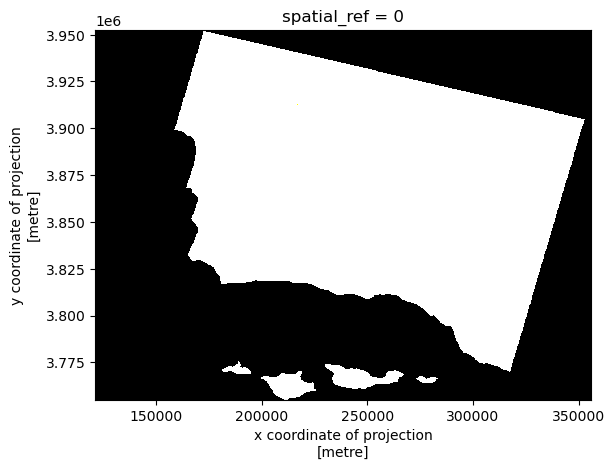

In [8]:
# select bands from landsat
landsat[["red", 
         "green", 
         "blue"]].to_array().plot.imshow() 

Adjust the scale used for plotting the bands to get a true color image. 
HINT: [Check the `robust` parameter](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html)
The issue here is the clouds: their RGB values are outliers and cause the other values to be squished when plotting. 

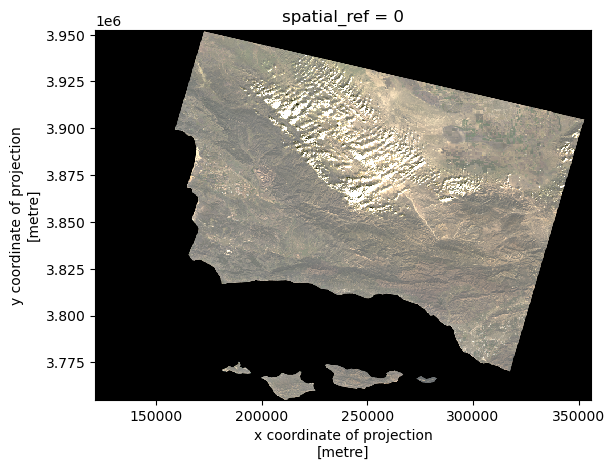

In [9]:
# select bands from landsat
landsat[["red", 
         "green", 
         "blue"]].to_array().plot.imshow(robust = True) 

## False color image
Without creating any new variables:

Create a false color image by plotting the short-wave infrared (swir22), near-infrared, and red variables (in that order).

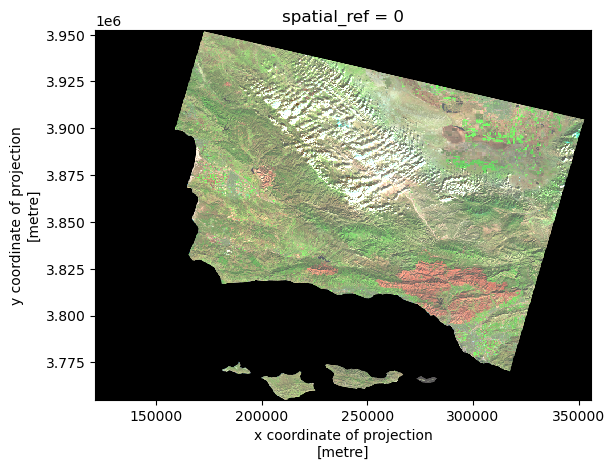

In [10]:
# select bands from landsat
landsat[["swir22", 
         "nir08", # plot nir layer
         "red"]].to_array().plot.imshow(robust = True) 

## Updates

If there are any updates needed to the data to create the map, perform them in the next cells (you may add as many as you need). 
Comment appropriately.

In [22]:
# update landsat crs to ca_fire crs 
landsat = landsat.rio.reproject(ca_fire.crs)

# save false color image as an array
landsat_false = landsat[["swir22",
                         "nir08", # plot nir layer
                         "red"]].to_array()

# make landsat bounds into bbox
bbox = gpd.GeoDataFrame({"id":1,
                         "geometry":[box(*landsat.rio.bounds())]},
                        crs = ca_fire.crs)

In [17]:
# select only the Thomas Fires
thomas_fire = ca_fire[ca_fire.fire_name == 'THOMAS']

thomas_fire

,index,objectid,year_,state,agency,unit_id,fire_name,inc_num,alarm_date,cont_date,...,gis_acres,comments,complex_na,complex_in,irwinid,fire_num,decades,shape_leng,shape_area,geometry
436,20274,41874,2017,CA,USF,VNC,THOMAS,00003583,2017-12-04,2018-01-12,...,281790.875,CONT_DATE based on Inciweb,None,None,None,None,2010,540531.887458,1.681106e+09,"MULTIPOLYGON (((-13316089.016 4088553.040, -13..."


## Map

Create a map showing the shortwave infrared/nir/ ed false color image together with the Thomas fire perimeter. 
Customize it appropriately.

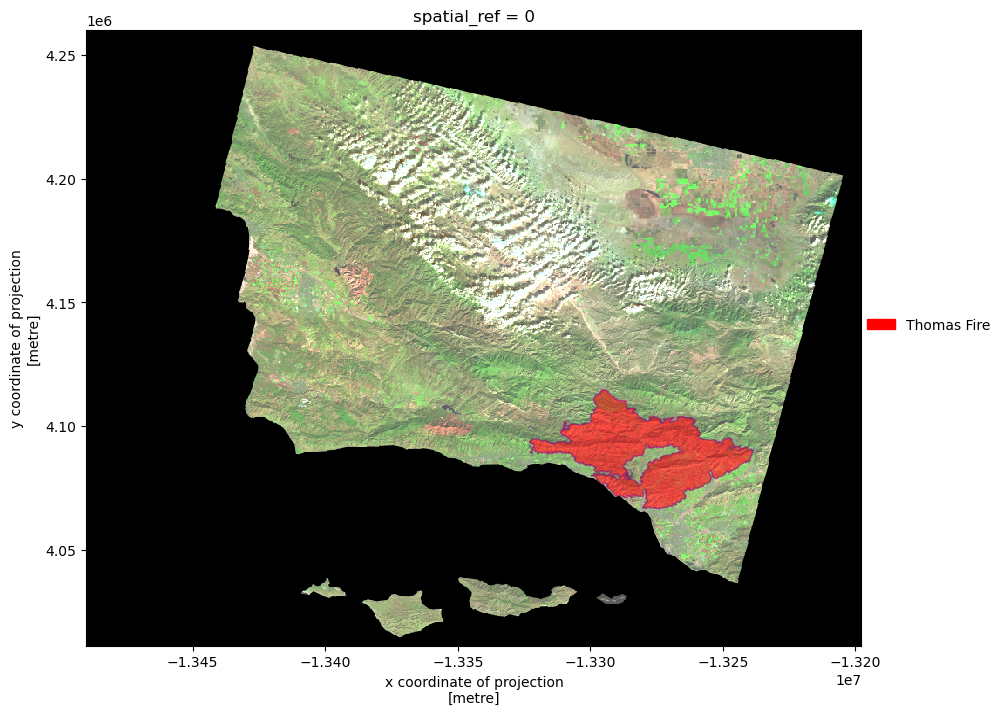

In [26]:
fig, ax = plt.subplots(figsize=(10,8))

# plot the fires
thomas_fire.plot(ax = ax,
                 color = "red",
                edgecolor = "purple", # make border around shapefile
                alpha = 0.5) # make transparent
fire_patch = mpatches.Patch(color = "red",
                          label = "Thomas Fire")

# plot the false landsat
landsat_false.plot.imshow(ax = ax,
                          robust = True) 

ax.legend(handles = [fire_patch], # which labels to show 
          frameon = False, # no border around legend
          loc=(1, 0.5)) # where legend is located
 

plt.show()

## Final code

Collect all the relevant code into the first blank cell of the notebook titled "FINAL CODE". This single cell will have the end-to-end workflow: from importing libraries and loading the data, to producing the graph. The only ouput of this cell should be the plot you produced in the previous exercise. 

Add divisions for relevant sections and comment appropriately.